The aim of this notebook is to calculate and store most similar superpatches
so that they can be used further for pretraining.

Follow-up to `notebooks/demo_vit.ipynb`.

# Setup, constants & imports

In [1]:
# TODO: review code

In [2]:
MODEL = 'vit_base_patch16_224.dino'
# MODEL = 'vit_tiny_patch16_224.augreg_in21k'
PATCH_SIZE = 16

N_AGG = 8  # N_AGG x N_AGG patches consitute superpatch
N_NEAREST = 8  # How many nearest neighbors to save

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
NUM_WORKERS = 2
DATA_DIR = '../data/val2017'

VIS_N_SUPERPATCHES_TO_SAMPLE = 8  # How many superpatches to sample for visualization
VIS_N_SIMILAR = 6  # How many most similar superpatches to show per sampled superpatch

# For how many vectors to get sorted nearest neighbors at once in the loop
# It depends on the GPU memory and dataset size
PROCESS_AT_ONCE = 256

In [3]:
# Run only if using Colab

! wget http://images.cocodataset.org/zips/train2017.zip
! mkdir data
! unzip -qq train2017.zip -d data

! pip install timm

N_NEAREST = 32
DATA_DIR = 'data/train2017'

--2023-11-25 13:35:22--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.104.137, 52.216.51.217, 52.216.208.121, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.104.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  37.6MB/s    in 21s     

2023-11-25 13:35:43 (36.3 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.4 MB/s eta 0:00:00


In [4]:
import random
import json

from pathlib import Path

import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import timm

from tqdm import tqdm

from torch import nn
from torch.utils.data import Dataset, DataLoader

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Asserts

In [6]:
assert IMG_HEIGHT % PATCH_SIZE == 0
assert IMG_WIDTH % PATCH_SIZE == 0
assert IMG_HEIGHT % (N_AGG*PATCH_SIZE) == 0
assert IMG_WIDTH % (N_AGG*PATCH_SIZE) == 0

# Load data

In [7]:
class ImgsDataset(Dataset):
  def __init__(self, paths, transform):
    self.paths = paths
    self.transform = transform

  def __getitem__(self, index):
    img = PIL.Image.open(self.paths[index]).convert('RGB')
    return self.transform(img)

  def __len__(self):
    return len(self.paths)

In [8]:
paths = sorted(Path(DATA_DIR).rglob('*'))
paths

In [9]:
transform = [
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
]

ds = ImgsDataset(paths, transforms.Compose(transform))
loader = DataLoader(
    ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available()
)

In [10]:
transform_orig = [
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH))
]

ds_orig = ImgsDataset(paths, transforms.Compose(transform_orig))

# Load model

In [11]:
timm.list_models('vit_tiny_*', pretrained=True)

['vit_tiny_patch16_224.augreg_in21k',
 'vit_tiny_patch16_224.augreg_in21k_ft_in1k',
 'vit_tiny_patch16_384.augreg_in21k_ft_in1k',
 'vit_tiny_r_s16_p8_224.augreg_in21k',
 'vit_tiny_r_s16_p8_224.augreg_in21k_ft_in1k',
 'vit_tiny_r_s16_p8_384.augreg_in21k_ft_in1k']

In [12]:
model = timm.create_model(
    MODEL,
    pretrained=True,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    num_classes=0,
    global_pool=''
).to(device).eval()

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

# Compute vectors and save nearest neighbors

In [13]:
vectors_all = []

for imgs in tqdm(loader):
    with torch.no_grad():
        # Skip [CLS] token
        vectors = model(imgs.to(device))[:, 1:, :]

        # (B, H*W, C) -> (B, H, W, C)
        vectors = vectors.view(
            vectors.shape[0], IMG_HEIGHT//PATCH_SIZE, IMG_WIDTH//PATCH_SIZE, vectors.shape[2]
        )

        # (B, H, W, C) -> (B, C, H, W)
        vectors = vectors.permute(0, 3, 1, 2)

        # Get superpatches representations
        vectors = nn.AvgPool2d(N_AGG, count_include_pad=False)(vectors)

        # (B, C, H, W) -> (B, H, W, C)
        vectors = vectors.permute(0, 2, 3, 1)

        # (B, H, W, C) -> (B*H*W, C)
        # Get flattened superpatches representations
        vectors = vectors.flatten(0, 2)

        vectors_all.append(vectors.cpu())

vectors_all = torch.cat(vectors_all)
vectors_all.shape

100%|██████████| 625/625 [01:19<00:00,  7.83it/s]


torch.Size([20000, 768])

In [14]:
@torch.no_grad()
def get_similarities(a, b, eps=1e-8):
    norm_a, norm_b = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]

    a_norm = a / torch.max(norm_a, eps*torch.ones_like(norm_a))
    b_norm = b / torch.max(norm_b, eps*torch.ones_like(norm_b))

    similarities = torch.mm(a_norm, b_norm.transpose(0, 1))

    return similarities

In [15]:
nns_dict = {}
vectors_all = vectors_all.to(device)  # Move back to GPU if available

n_iters = vectors_all.shape[0] // PROCESS_AT_ONCE + 1
for iter_idx in tqdm(range(n_iters)):
    start_idx = int(iter_idx*PROCESS_AT_ONCE)
    end_idx = int(min(start_idx+PROCESS_AT_ONCE, vectors_all.shape[0]))

    similarities = get_similarities(
        vectors_all[start_idx : end_idx], vectors_all
    )

    most_similar = torch.argsort(
        similarities, dim=1, descending=True
    )[:, 1:].cpu().tolist()  # Skip identical crop

    for i in range(len(most_similar)):
        nns_dict[start_idx+i] = most_similar[i][:N_NEAREST]

with open('nns.json', 'w') as f:
    json.dump(nns_dict, f)

100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


# Visualize results

In [16]:
with open('nns.json', 'r') as f:
    nns_dict = json.load(
        f,
        # Convert keys to integers during loading
        object_pairs_hook=lambda x: {int(k): v for k, v in x}
    )

In [17]:
def overlay_superpatch_by_index(superpatch_idx):
    n_superpatch_cols_per_img = IMG_WIDTH // PATCH_SIZE // N_AGG
    n_superpatch_rows_per_img = IMG_HEIGHT // PATCH_SIZE // N_AGG
    n_superpatchs_per_img = n_superpatch_cols_per_img * n_superpatch_rows_per_img

    img_idx = superpatch_idx // n_superpatchs_per_img
    local_superpatch_idx = superpatch_idx % n_superpatchs_per_img
    superpatch_row_idx = local_superpatch_idx // n_superpatch_cols_per_img
    superpatch_col_idx = local_superpatch_idx % n_superpatch_cols_per_img

    y_upper = superpatch_row_idx * PATCH_SIZE * N_AGG
    x_upper = superpatch_col_idx * PATCH_SIZE * N_AGG
    y_lower = (superpatch_row_idx+1) * PATCH_SIZE * N_AGG
    x_lower = (superpatch_col_idx+1) * PATCH_SIZE * N_AGG

    img_w_crop = np.copy(ds_orig[img_idx])
    cv2.rectangle(
        img_w_crop,
        (x_upper, y_upper),
        (x_lower, y_lower),
        (0, 255, 0)
    )

    return img_w_crop

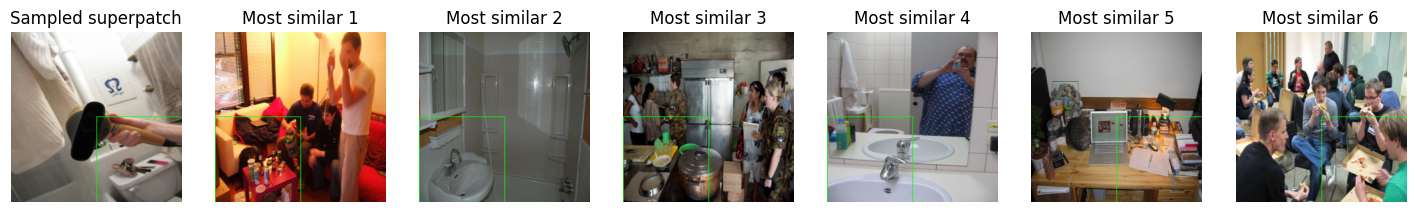

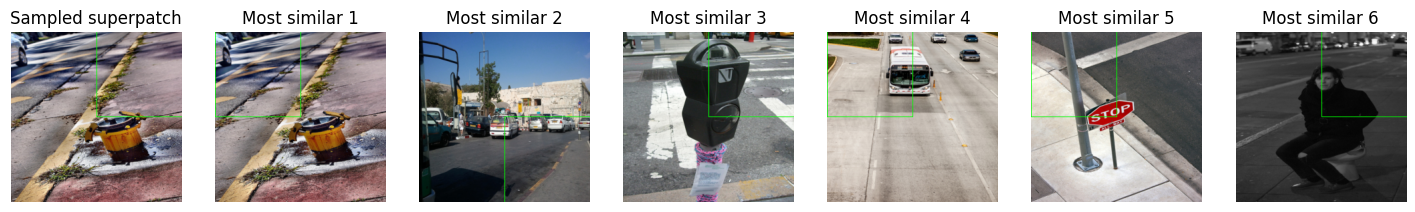

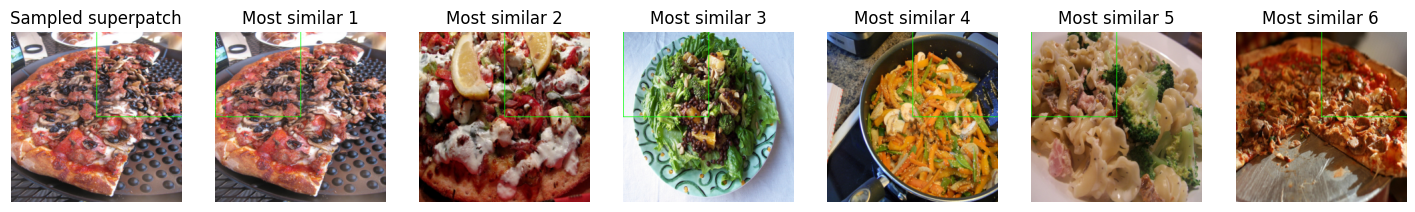

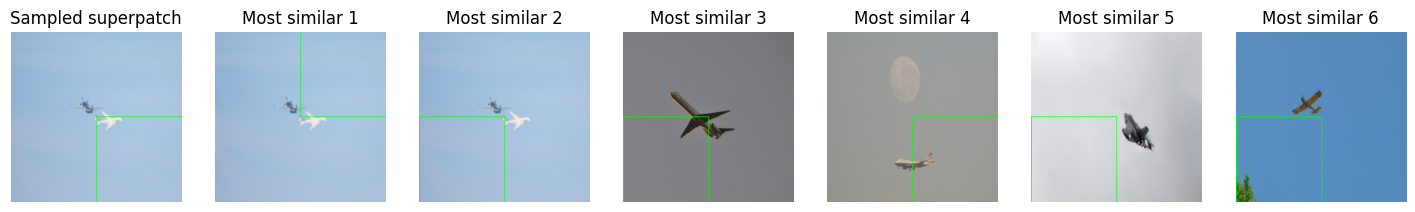

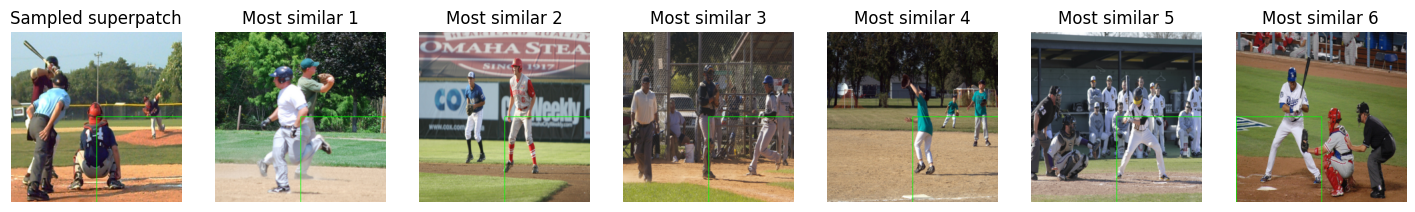

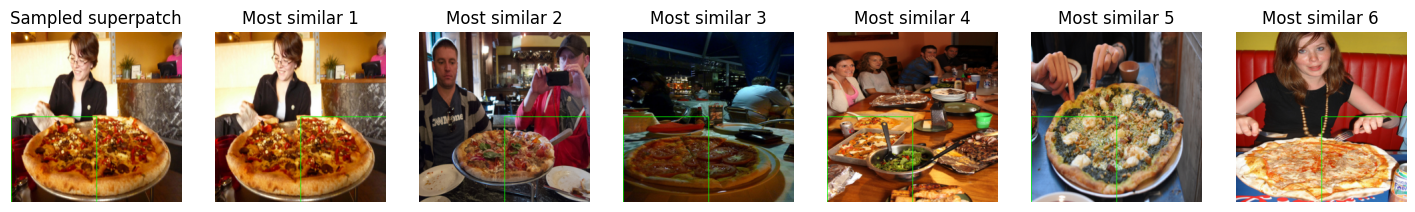

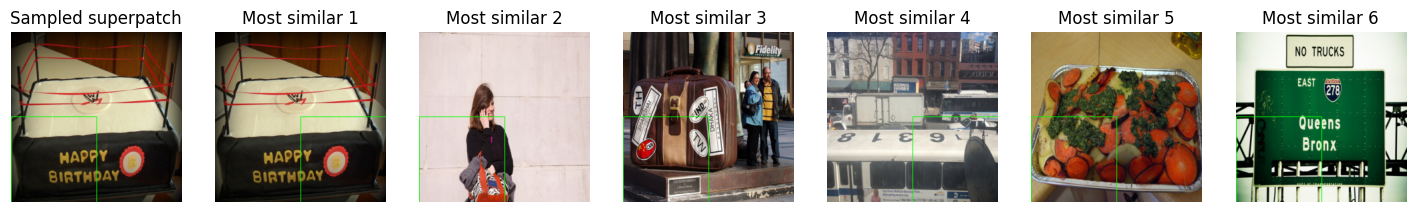

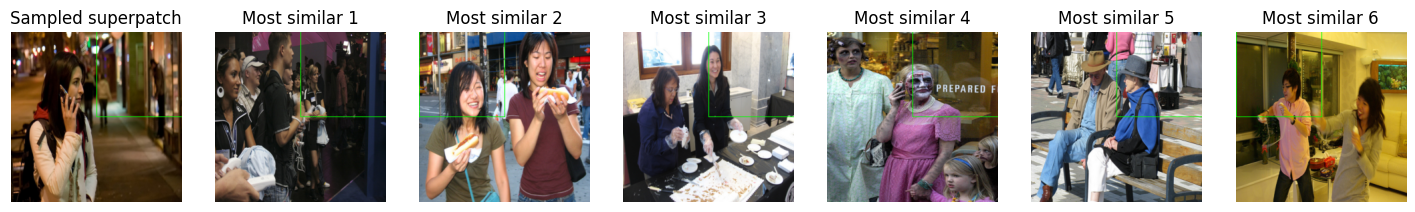

In [18]:
superpatch_idxs = random.sample(
    list(nns_dict.keys()),
    VIS_N_SUPERPATCHES_TO_SAMPLE
)

for superpatch_idx in superpatch_idxs:
    fig, axs = plt.subplots(
        1, VIS_N_SIMILAR+1, figsize=(VIS_N_SIMILAR*3, 5)
    )
    for ax in axs:
        ax.axis('off')

    axs[0].imshow(overlay_superpatch_by_index(superpatch_idx))
    axs[0].set_title('Sampled superpatch')
    for i in range(VIS_N_SIMILAR):
        axs[i+1].imshow(overlay_superpatch_by_index(nns_dict[superpatch_idx][i]))
        axs[i+1].set_title(f'Most similar {i+1}')
    plt.show()
    plt.close()